# Statistical analysis of the generated cell positions

This notebook contains some codes that analyze the cell position data generated from pycabnn.

In [59]:
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

## Load data

Here we load the sample cell position data.

In [2]:
# A few utility functions to p

def limit_to_box(x, box):
    """select only the points within a given box."""
    mf = x.copy()
    for i, t in enumerate(box):
        mf = mf[mf[:, i] >= t[0], :]
        mf = mf[mf[:, i] <= t[1], :]
    return mf

def print_range(goc):
    """prints the 3d range occupied by the cell population"""
    print(
        "Current range:\n",
        "x: [{}, {}]\n".format(goc[:, 0].min(), goc[:, 0].max()),
        "y: [{}, {}]\n".format(goc[:, 1].min(), goc[:, 1].max()),
        "z: [{}, {}]".format(goc[:, 2].min(), goc[:, 2].max()),
    )

def fix_coords(x, bbox):
    """removes the cells in a 25 um-wide gutter."""
    y = x - 25
    y = limit_to_box(y, bbox)
    print_range(y)
    return y


In [3]:
# load the data
fname = "../../test_data/generated_positions/coords_20190626_1_6.npz"
f = np.load(fname)
f['grc_nop'].shape # grc_nop is grc positions without perturbation

# readjuct the data to the bounding box - note that the data were generated in a larger volume
bbox = [[0, 700], [0, 700], [0, 200]]
grc = fix_coords(f['grc_nop'], bbox) # here we use the unperturbed position
glo = fix_coords(f['glo'], bbox)
grx = grc + np.random.randn(*grc.shape)*0.2 # add perturbation, corresponding to the softness margin, 0.2 um here.


Current range:
 x: [0.008738726727301582, 699.9951413085064]
 y: [0.0056677228167814064, 699.9989124811175]
 z: [0.0020255851778578915, 199.99996645157134]
Current range:
 x: [0.0003566497912323996, 699.9434720937548]
 y: [0.03680411733359179, 699.9969905094972]
 z: [0.0011508231361929688, 199.98956118528915]


## Simple distance-based GrC-Glo connection

Here we demonstrate and analyze the GrC-glomerulus connectivity based on the simple distance-based rule.

## Pycabnn-generated cell position

In [132]:
## [0,1,2] = [mediolateral, sagittal, z]
## we first rescale the sagittal direction to make the connection stretch more in the sagittal direction

scale_factor = 1/4

src = glo.copy() #GL
tgt = grx.copy() #GrC

src[:, 1] *= scale_factor
tgt[:, 1] *= scale_factor

In [32]:
rr = 7.85
nn = NearestNeighbors()
nn.fit(src)
conns = nn.radius_neighbors(tgt, radius=rr, return_distance=False)
print("connection list = ", conns)

connection list =  [array([24439,  7510,  9711, 38567, 44375,  6622])
 array([23850, 14883, 16094, 53010])
 array([51504, 10381, 41401,  8627,  1244]) ...
 array([34542, 38056, 22814]) array([48580, 35881, 32586])
 array([ 7809,  6599, 31167, 27955, 46612])]


In [34]:
# Check the number of GrC is the same as the length of the connection list
assert tgt.shape[0] == conns.shape[0]

In [107]:
# Transform conns into the pandas table

def transform_conns_table(conns):
    Nconns = sum(c.size for c in conns)

    src = np.zeros(Nconns, dtype='int')
    tgt = np.zeros(Nconns, dtype='int')

    count = 0
    for i in trange(conns.size):
        n = conns[i].size
        tgt[count:(count+n)] = i
        src[count:(count+n)] = conns[i]
        count +=n

    return pd.DataFrame({'src':src, 'tgt':tgt})

df_conns = transform_conns_table(conns)
df_conns

  0%|          | 0/181527 [00:00<?, ?it/s]

,src,tgt
0,24439,0
1,7510,0
2,9711,0
3,38567,0
4,44375,0
...,...,...
804039,7809,181526
804040,6599,181526
804041,31167,181526
804042,27955,181526


### Now we analyze the connectivityhist

N conns per GrC = 4.434563434502766 ± 1.3565512932630999
N conns per GL = 15.128396176714082 ± 3.4410763879196278


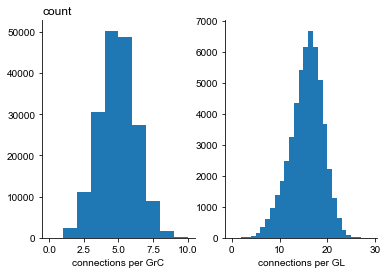

In [120]:
def plot_conns(df_conns):
    nconns_per_grc = df_conns.groupby('tgt').count().values.ravel()
    nconns_per_gl = df_conns.groupby('src').count().values.ravel()

    print('N conns per GrC = {} ± {}'.format(np.mean(nconns_per_grc), np.std(nconns_per_grc)))
    print('N conns per GL = {} ± {}'.format(np.mean(nconns_per_gl), np.std(nconns_per_gl)))

    _, (ax1, ax2) = plt.subplots(ncols=2)
    n_r, x_r, _ = ax1.hist(nconns_per_grc, np.arange(nconns_per_grc.max()),10)
    ax1.set_title('count', loc="left")
    ax1.set(xlabel='connections per GrC')

    _ = ax2.hist(nconns_per_gl, np.arange(nconns_per_gl.max()),10)
    ax2.set(xlabel='connections per GL')

plot_conns(df_conns)

### Dendrite length

In [147]:
src = glo.copy() #GL
tgt = grx.copy() #GrC

src_coord = src[df_conns.src.values.ravel(),:]
tgt_coord = tgt[df_conns.tgt.values.ravel(),:]

In [146]:
print(tgt.shape)
print(df_conns.tgt.values.ravel().max()

(181527, 3)
181526


In [148]:
delta = tgt_coord-src_coord
dend_length = np.sqrt((delta**2).sum(axis=1))

(array([ 24876., 105360., 149700., 159448., 147080., 115997.,  71482.,
         24361.,   5220.,    520.]),
 array([  2.95111649,  99.86053777, 196.76995905, 293.67938033,
        390.58880161, 487.49822289, 584.40764416, 681.31706544,
        778.22648672, 875.135908  , 972.04532928]),
 <BarContainer object of 10 artists>)

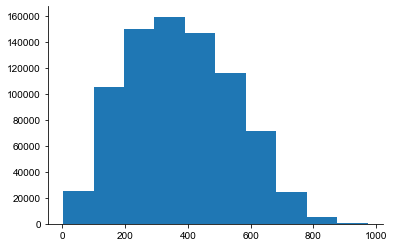

In [152]:
plt.hist(dend_length)

## Comparison with random cell positions

The same connectivity analysis with the purely random cell positions. The result can be slightly different from the numbers that we reported in the paper --- since it is random!

In [118]:
# generate the purely rarndom cell position
grx = np.random.rand(*grx.shape)
glo = np.random.rand(*glo.shape)

grx[:,0] *= 700
grx[:,1] *= 700
grx[:,2] *= 200

glo[:,0] *= 700
glo[:,1] *= 700
glo[:,2] *= 200

scale_factor = 1/4

# grx = grc + np.random.randn(*grc.shape)*0.2

src = grx.copy()
tgt = glo.copy()
src[:, 1] *= scale_factor
tgt[:, 1] *= scale_factor

In [125]:
nn = NearestNeighbors()
nn.fit(tgt)
df_rand = transform_conns_table(nn.radius_neighbors(src, radius=rr, return_distance=False))

  0%|          | 0/181527 [00:00<?, ?it/s]

N conns per GrC = 4.307813410425351 ± 2.043862921293718
N conns per GL = 14.467016632798977 ± 4.118770808935937


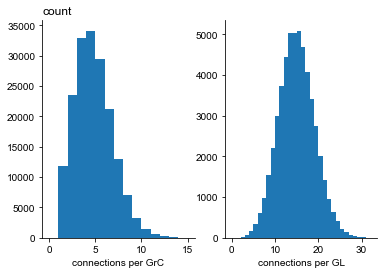

In [126]:
plot_conns(df_rand)